## Rossmann Store Sales
### Test challenge
Goal: Explore data and predict 6 weeks of daily sales for 1,115 stores located across Germany. 
As it usually goes, we start with the Exploratory Data Analysis of the main metrics revealing present trends and patterns in the data, giving a solid foundation for the further causal analysis.
Also, alternatively to forecasting with Prophet, I use one of the most robust and sophisticated algorithm Extreme Gradient Boosting for regression.

In [2]:
import warnings
warnings.filterwarnings("ignore")

# loading packages
# basic + dates 
import numpy as np
import pandas as pd
from pandas import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline

# statistics
from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# prophet by Facebook
from fbprophet import Prophet

# machine learning: XGB
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost.sklearn import XGBRegressor # wrapper

In [3]:
# importing train data to learn
train = pd.read_csv("train.csv", 
                    parse_dates = True, low_memory = False, index_col = 'Date')

# additional store data
store = pd.read_csv("store.csv", 
                    low_memory = False)
# time series as indexes
train.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

## Explaratory Data Analysis

In this first section we go through the train and store data, handle missing values and create new features for further analysis.

In [4]:
# first glance at the train set: head and tail
print("In total: ", train.shape)
train.head(5).append(train.tail(5))

In total:  (1017209, 8)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1
2013-01-01,1111,2,0,0,0,0,a,1
2013-01-01,1112,2,0,0,0,0,a,1
2013-01-01,1113,2,0,0,0,0,a,1
2013-01-01,1114,2,0,0,0,0,a,1


Short description:
- Sales: the turnover for any given day (target variable).
- Customers: the number of customers on a given day.
- Open: an indicator for whether the store was open: 0 = closed, 1 = open.
- Promo: indicates whether a store is running a promo on that day.
- StateHoliday: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays.
- SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools.
- We are dealing with time series data so it will probably serve us to extract dates for further analysis. We also have two likely correlated vaiables in the dataset, which can be combined into a new feature.

In [5]:
# data extraction
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

# adding new variable
train['SalePerCustomer'] = train['Sales']/train['Customers']
train['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

On average customers spend about 9.50$ per day. Though there are days with Sales equal to zero.

## Missing values

Closed stores and zero sales stores

In [6]:
# closed stores
train[(train.Open == 0) & (train.Sales == 0)].head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-31,876,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-30,292,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-30,876,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-29,292,3,0,0,0,1,0,1,2015,7,29,31,NaN


There're 172817 closed stores in the data. It is about 10% of the total amount of observations. To avoid any biased forecasts we will drop these values.

What about opened stores with zero sales?

In [7]:
# opened stores with zero sales
zero_sales = train[(train.Open != 0) & (train.Sales == 0)]
print("In total: ", zero_sales.shape)
zero_sales.head(5)

In total:  (54, 13)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-05-15,971,5,0,0,1,0,0,1,2015,5,15,20,NaN
2015-03-26,674,4,0,0,1,0,0,0,2015,3,26,13,NaN
2015-02-05,699,4,0,0,1,1,0,0,2015,2,5,6,NaN
2014-10-01,708,3,0,0,1,1,0,0,2014,10,1,40,NaN
2014-09-22,357,1,0,0,1,0,0,0,2014,9,22,39,NaN


Interestingly enough, there are opened store with no sales on working days. There're only 54 days in the data, so we can assume that there were external factors involved, for example manifestations.

In [8]:
print("Closed stores and days which didn't have any sales won't be counted into the forecasts.")
train = train[(train["Open"] != 0) & (train['Sales'] != 0)]

print("In total: ", train.shape)

Closed stores and days which didn't have any sales won't be counted into the forecasts.
In total:  (844338, 13)


What about store information:

In [9]:
# additional information about the stores
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


Store: a unique Id for each store
- Storetype: differentiates between 4 different store models: a,b,c,d 
- Assortment: describes an assortment level: a=basic, b =extra, c =extended
- CompitionDistance: distance in meters to the nearest competitor store
- CompitionOPenSince[Month/Year]: gives the approximate year and month of the time the nearest competitor was opened
- Promo2: Promo2 is a continuing a promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week]: describes the year and calendar week when the store started participating in Promo2
- PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started. 
- E.g. "Feb, May, Aug, Nov" means each round starts in February, May, August, November of any given year for that store 


In [10]:
# missing values?
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

We have few variables with missing values that we need to deal with. Let's start with the CompetitionDistance.

In [11]:
# missing values in CompetitionDistance
store[pd.isnull(store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


Apperently this information is simply missing from the data. No particular pattern observed. In this case, it makes a complete sense to replace NaN with the median values (which is twice less that the average).

In [12]:
# fill NaN with a median value (skewed distribuion)
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

Continuing further with missing data. What about Promo2SinceWeek? May it be that we observe unsusual data points?

In [13]:
# no promo = no information about the promo?
_ = store[pd.isnull(store.Promo2SinceWeek)]
_[_.Promo2 != 0].shape

(0, 10)

No, if there's no Promo2 then there's no information about it. We can replace these values by zeros. The same goes for tha variables deducted from the competition, CompetitionOpenSinceMonth and CompetitionOpenSinceYear.

In [14]:
# replace NA's by 0
store.fillna(0, inplace = True)

In [15]:
print("Joining train set with an additional store information.")

# by specifying inner join we make sure that only those observations 
# that are present in both train and store sets are merged together
train_store = pd.merge(train, store, how = 'inner', on = 'Store')

print("In total: ", train_store.shape)
train_store.head()

Joining train set with an additional store information.
In total:  (844338, 22)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


## Store types

In this section we will closely look at different levels of StoreType and how the main metric Sales is distributed among them.

In [16]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


StoreType B has the highest average of Sales among all others, however we have much less data for it. So let's print an overall sum of Sales and Customers to see which StoreType is the most selling and crowded one:

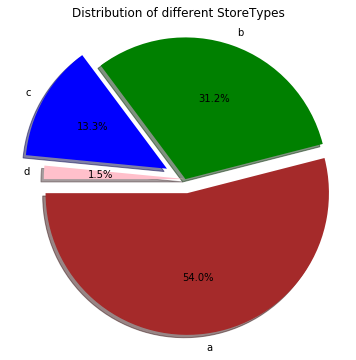

In [19]:
labels = 'a' , 'b' , 'c' , 'd'
sizes = store.StoreType.value_counts()
colors = ['brown', 'green' , 'blue' , 'pink']
explode = (0.1, 0.0 , 0.15 , 0.0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=180)
plt.axis('equal')
plt.title("Distribution of different StoreTypes")
plt.plot()
fig=plt.gcf()
fig.set_size_inches(6,6)
plt.show()

In [18]:
train_store.groupby('StoreType')['Customers', 'Sales'].sum()

,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


Clearly stores of type A. StoreType D goes on the second place in both Sales and Customers. What about date periods? Seaborn's facet grid is the best tool for this task:

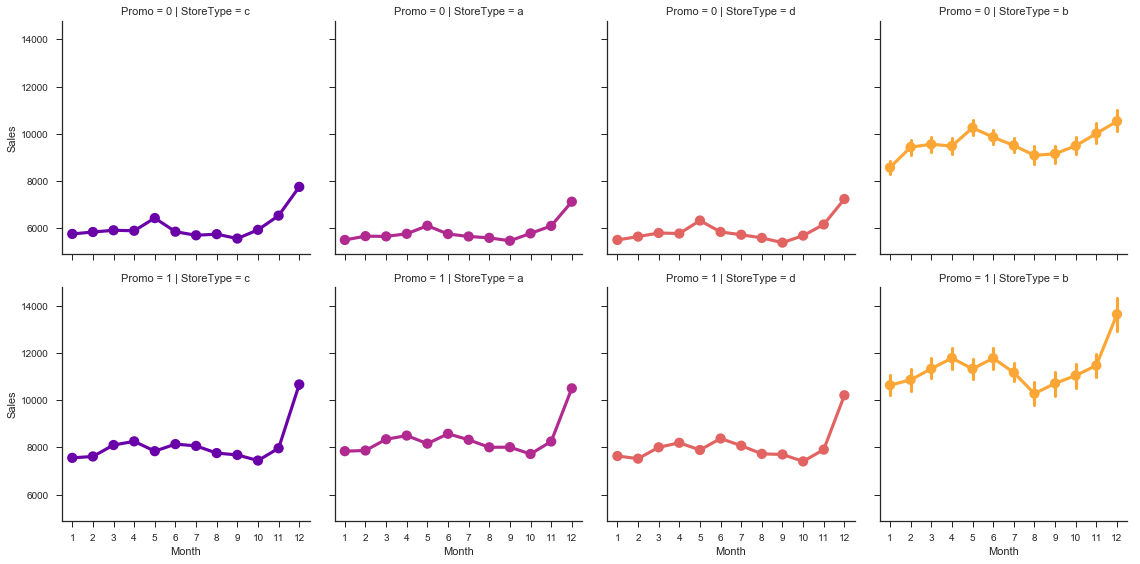

In [198]:
# sales trends
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c)

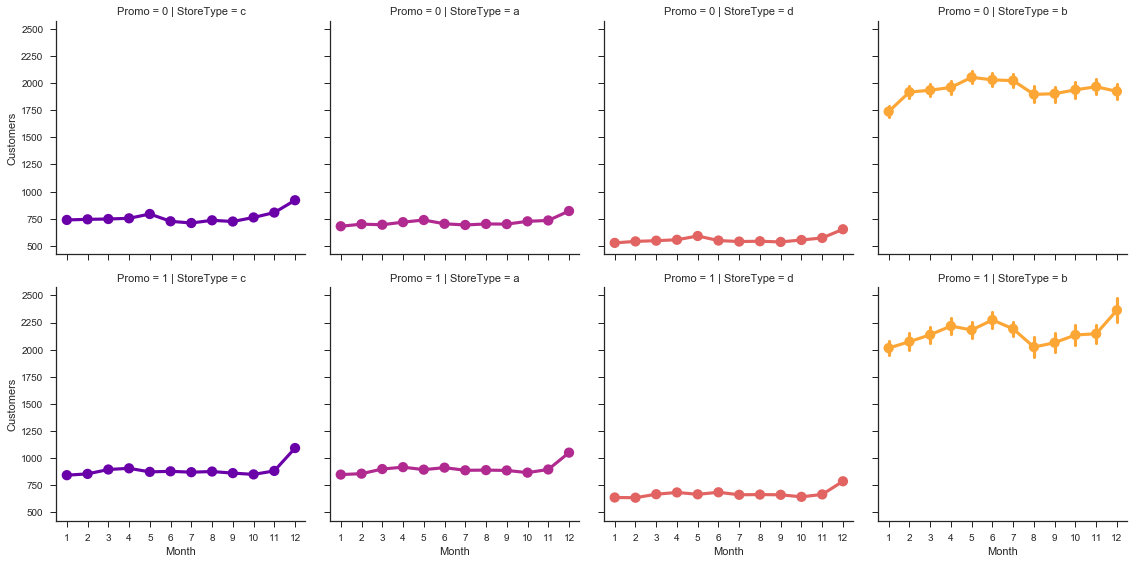

In [199]:
# sales trends
sns.factorplot(data = train_store, x = 'Month', y = "Customers", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c)

All store types follow the same trend but at different scales depending on the presence of the (first) promotion Promo and StoreType itself (case for B).
### Already at this point, we can see that Sales escalate towards Christmas holidays. 

In [173]:
def plotmaster(StringA , StringB):
  fig, axes = plt.subplots(3,1)
  fig.set_size_inches(12, 15)
  sns.barplot(x=StringA, y=StringB, data=store ,hue="StoreType", ax = axes[0])
  sns.boxplot(x=StringA, y=StringB, data=store ,hue="StoreType", ax=axes[1])
  sns.violinplot(x=StringA, y=StringB, data=store, hue="StoreType" , ax=axes[2])

In [174]:
temp = []
for i in train.groupby('Store')[["Sales", "Customers"]].mean()["Sales"]:
  temp.append(i)
store["Sales"] = temp

In [175]:
temp = []
for i in train.groupby('Store')[["Sales", "Customers"]].mean()["Customers"]:
  temp.append(i)
store["Customers"] = temp

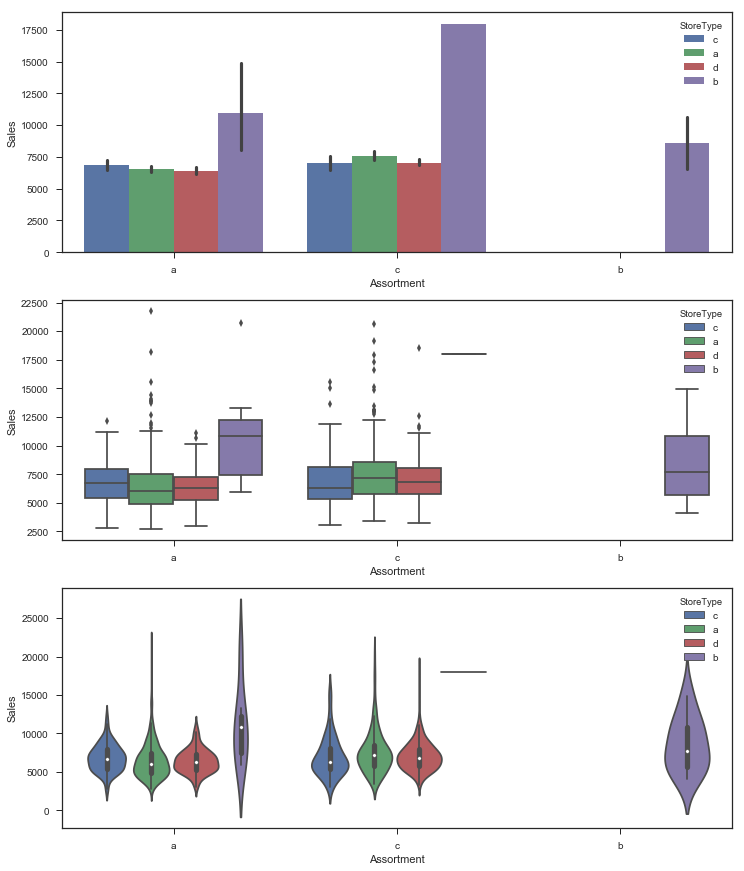

In [176]:
plotmaster("Assortment" , "Sales")

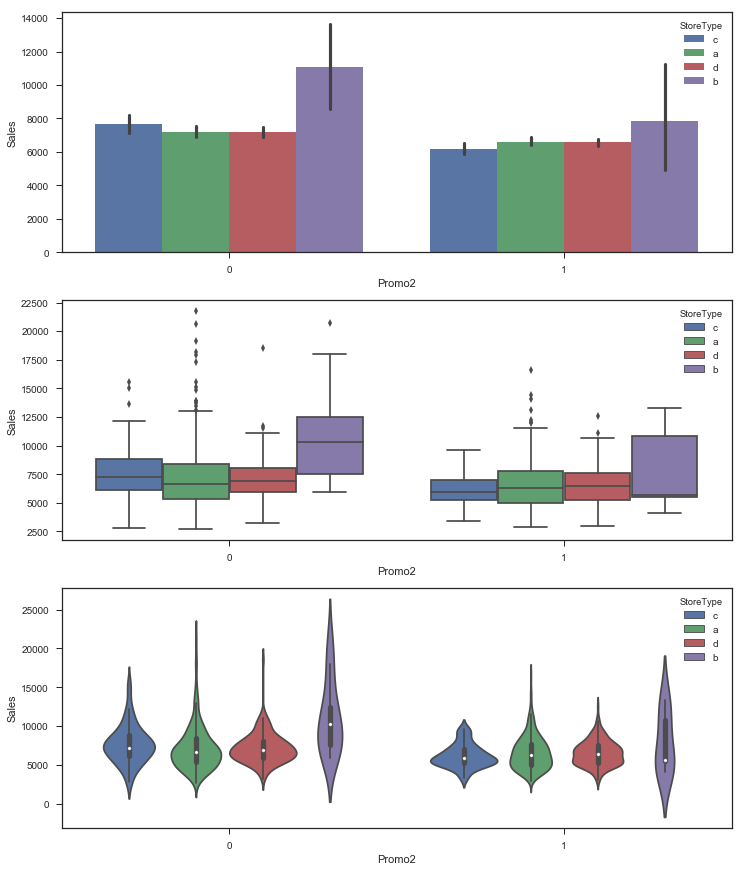

In [177]:
plotmaster("Promo2" , "Sales")

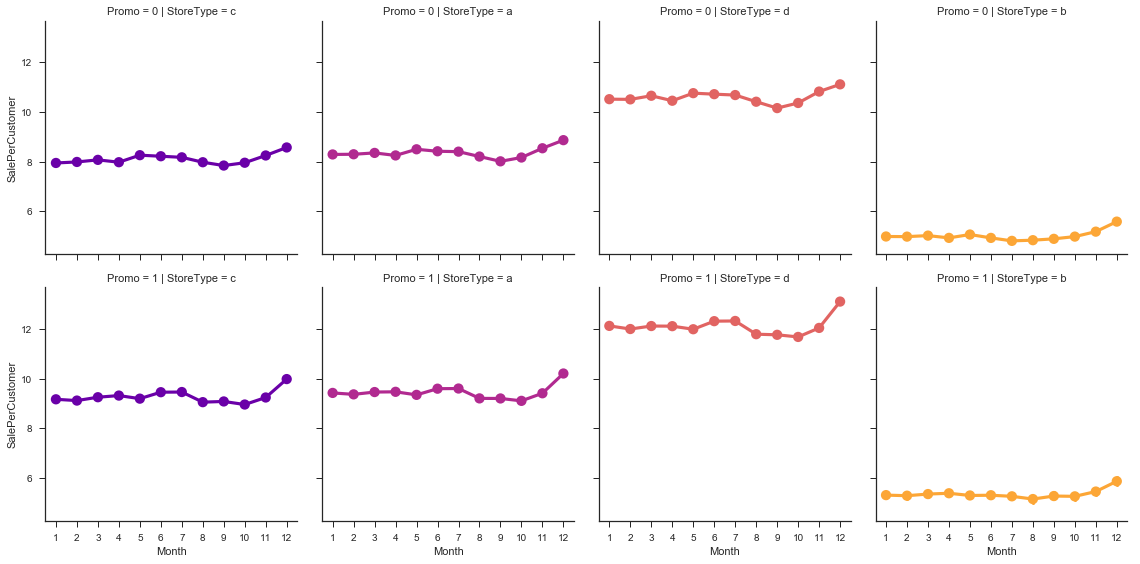

In [178]:
# sale per customer trends
sns.factorplot(data = train_store, x = 'Month', y = "SalePerCustomer", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c)

Eventhough the plots above showed StoreType B as the most selling and performant one, in reality it is not true. The highest SalePerCustomer amount is observed at the StoreType D, about 12€ with Promo and 10€ without. As for StoreType A and C it is about 9€.
Low SalePerCustomer amount for StoreType B describes its Buyer Cart: there are a lot of people who shop essentially for "small" things (or in a little quantity). Plus we saw that overall this StoreType generated the least amount of sales and customers over the period.

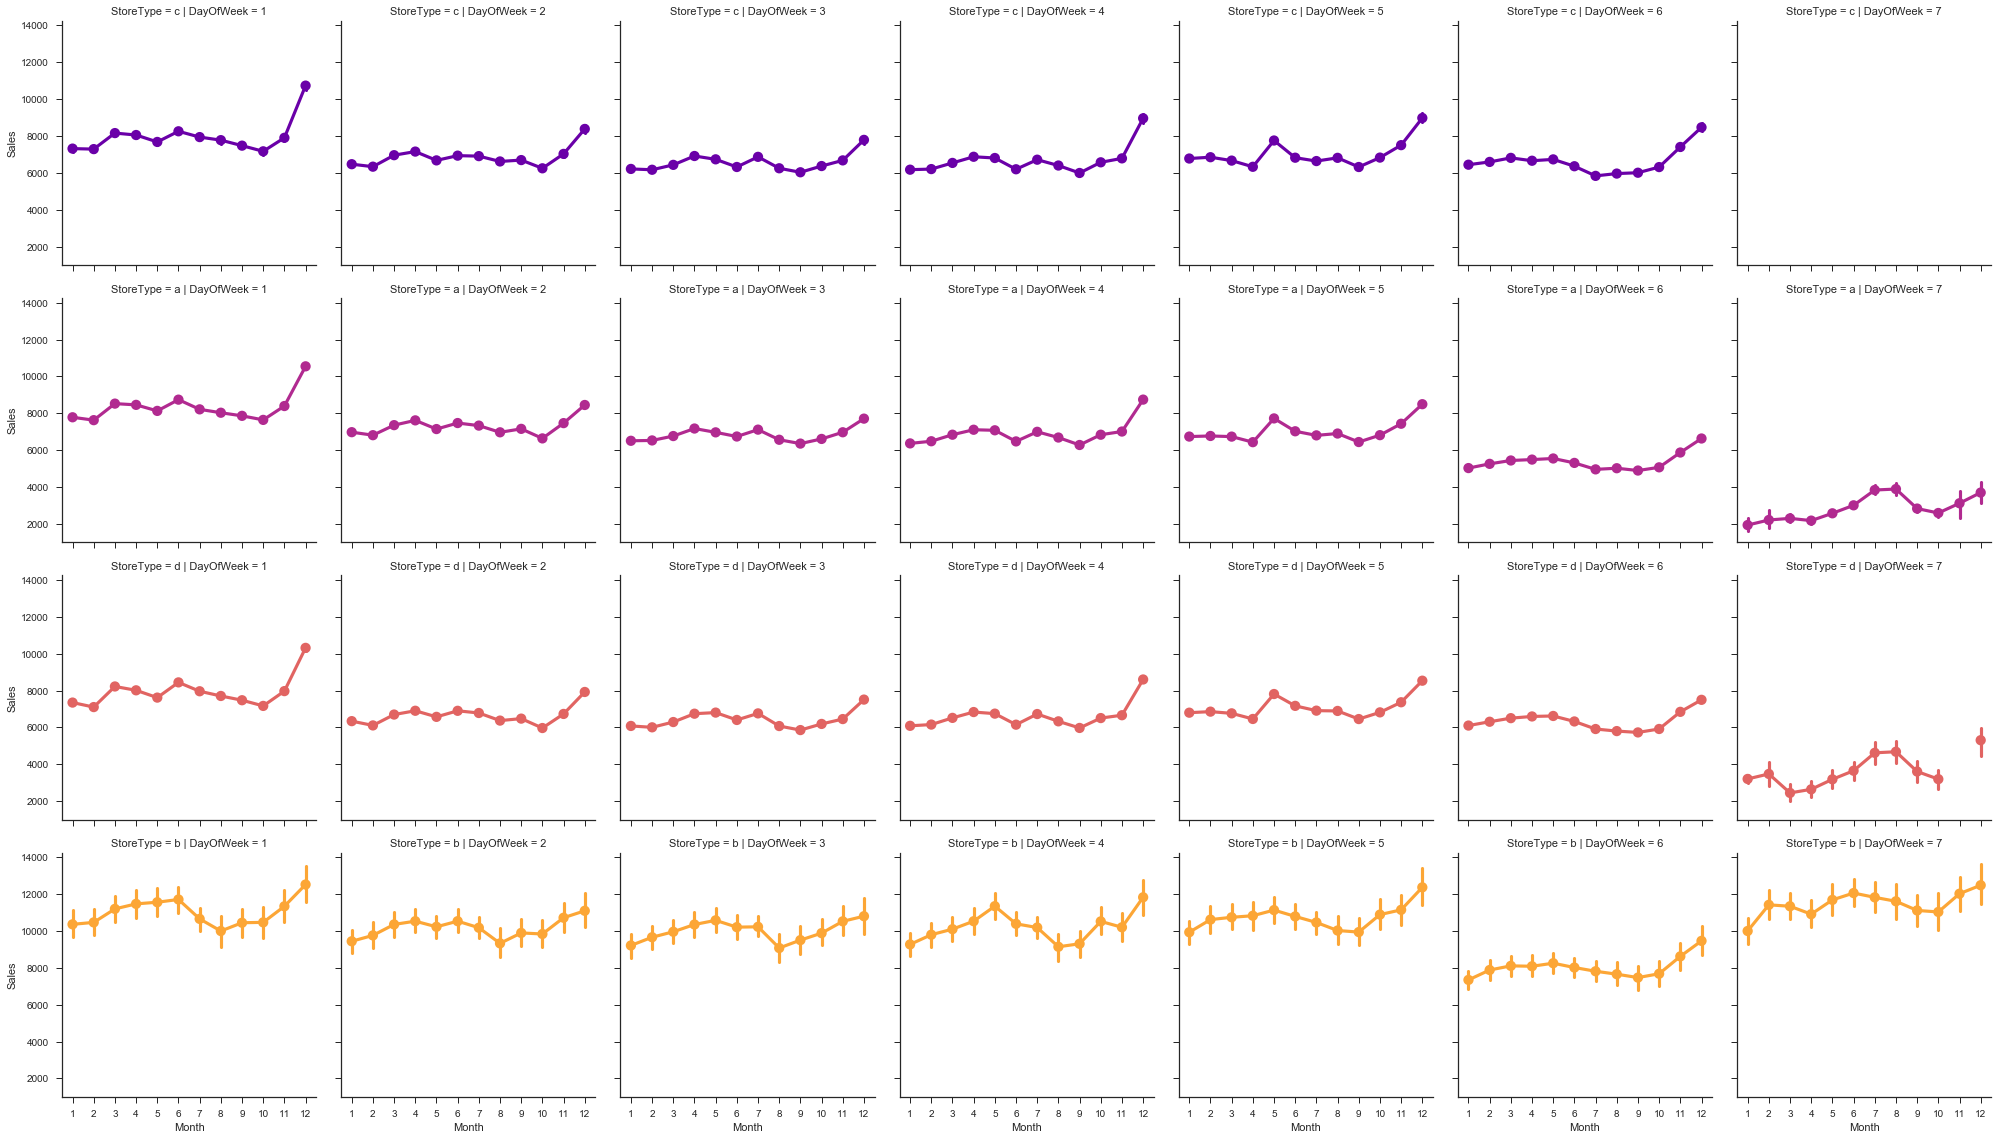

In [179]:
# customers
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'DayOfWeek', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'StoreType', # per store type in rows
               color = c)

We see that stores of Store Type C are all closed on Sundays, whereas others are most of the time opened. Interestingly enough, stores of Store Type D are closed on Sundays only from October to December.


### By the way what are the stores which are opened on Sundays?

In [135]:
# stores which are opened on Sundays
train_store[(train_store.Open == 1) & (train_store.DayOfWeek == 7)]['Store'].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  877,  931,  948, 1045, 1081, 1097, 1099])

To complete our preliminary data analysis, we can add variables describing the period of time during which competition and promotion were opened:


In [136]:
# competition open time (in months)
train_store['CompetitionOpen'] = 12 * (train_store.Year - train_store.CompetitionOpenSinceYear) + \
        (train_store.Month - train_store.CompetitionOpenSinceMonth)
    
# Promo open time
train_store['PromoOpen'] = 12 * (train_store.Year - train_store.Promo2SinceYear) + \
        (train_store.WeekOfYear - train_store.Promo2SinceWeek) / 4.0

# replace NA's by 0
train_store.fillna(0, inplace = True)

# average PromoOpen time and CompetitionOpen time per store type
train_store.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean()

,Sales,Customers,PromoOpen,CompetitionOpen
StoreType,,,,
a,6925.697986,795.422370,12918.492198,7115.514452
b,10233.380141,2022.211825,17199.328069,11364.495244
c,6933.126425,815.538073,12158.636107,6745.418694
d,6822.300064,606.353935,10421.916846,9028.526526


The most selling and crowded Store Type A doesn't appear to be the one the most exposed to competitors. Instead it's a Store Type B, which also has the longest running period of promotion.

### Correlational Analysis

We are finished with adding new variables to the data, so now we can check the overall correlations by plotting the seaborn heatmap:

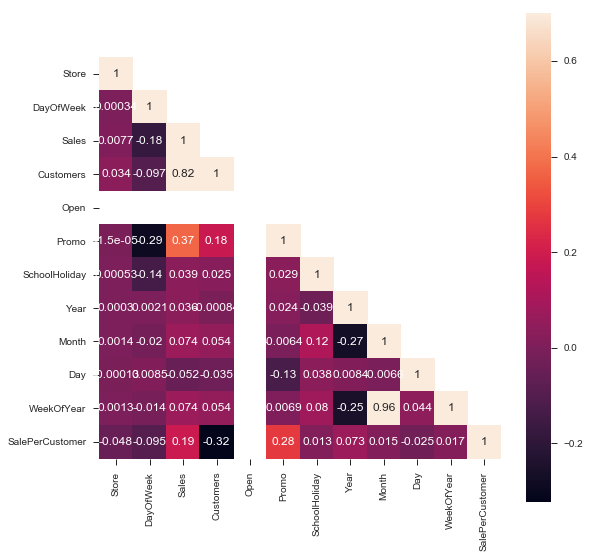

In [137]:
correlation_map = train[train.columns].corr()
obj = np.array(correlation_map)
obj[np.tril_indices_from(obj)] = False
fig,ax= plt.subplots()
fig.set_size_inches(9,9)
sns.heatmap(correlation_map, mask=obj,vmax=.7, square=True,annot=True)

As mentioned before, we have a strong positive correlation between the amount of Sales and Customers of a store. We can also observe a positive correlation between the fact that the store had a running promotion (Promo equal to 1) and amount of Customers.
However, as soon as the store continues a consecutive promotion (Promo2 equal to 1) the number of Customers and Sales seems to stay the same or even decrease, which is described by the pale negative correlation on the heatmap. The same negative correlation is observed between the presence of the promotion in the store and the day of a week.

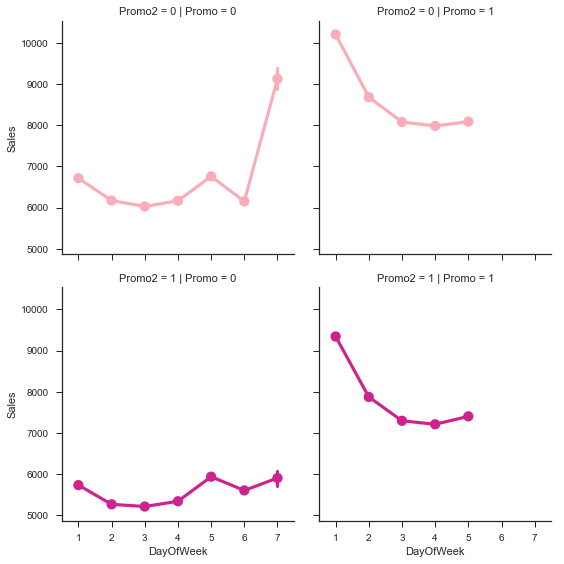

In [138]:
# sale per customer trends
sns.factorplot(data = train_store, x = 'DayOfWeek', y = "Sales", 
               col = 'Promo', 
               row = 'Promo2',
               hue = 'Promo2',
               palette = 'RdPu')

### There are several things here:
- In case of no promotion, both Promo and Promo2 are equal to 0, Sales tend to peak on Sunday (!). Though we should note that Storetype C doesn't work on Sundays. So it is mainly data from A,B,D Store type. 
- On the contrary, stores that run the promotion tend to make most of the sales on Monday. This fact could be a good indicator for Rossmann marketing campaigns. The same trend follow the stores which have both promotion at the same time (Promo and Promo2 are equal to 1).
- Promo2 alone doesn't seem to be correlated to any significant change in the Sales amount. This can be also prooved by the blue pale area on the heatmap above. 


### Conclusion of EDA
- The most selling and crowded Store Type is A.
- The best "Sale per Customer" Store Type D indicates to the higher Buyer Cart. We could also assume that the stores of this types are situated in the rural areas, so that customers prefer buying more but less often.
- Low Sale Per Customer amount for Store Type B indicates to the possible fact that people shop there essentially for small things. Which can also indicate to the label of this store type - "urban" - as it's more accessible for public, and customers don't mind shopping there from time to time during a week.
- Customers tends to buy more on Mondays when there's one promotion running (Promo) and on Sundays when there is no promotion at all (both Promo and Promo1 are equal to 0).
- Promo2 alone doesn't seem to be correlated to any significant change in the Sales amount.

### Time-Series Analysis per Store Type
- What makes a time series different from a regular regression problem?
- It is time dependent. The basic assumption of a linear regression that the observations are independent doesn’t hold in this case.
- Along with an increasing or decreasing trend, most time series have some form of seasonality trends, i.e. variations specific to a particular time frame. For example, for Christmas holidays, which we will see in this dataset.
- We build a time series analysis on store types instead of individual stores. The main advantage of this approach is its simplicity of presentation and overall account for different trends and seasonaltities in the dataset.
- In this section, we will analyse time series data: its trends, sesonalities and autocorrelation. Usually at the end of the analysis, we are able to develop a seasonal ARIMA (Autoregression Integrated Moving Average) model but it won't be our main focus today. Instead, we try to understand the data, and only later come up with the forecasts using Prophet methodology.

Seasonality
We take four stores from store types to represent their group:
Store number 2 for Store Type A
Store number 85 for Store Type B,
Store number 1 for Store Type C
Store number 13 for Store Type D.
It also makes sense to downsample the data from days to weeks using the resample method to see the present trends more clearly.

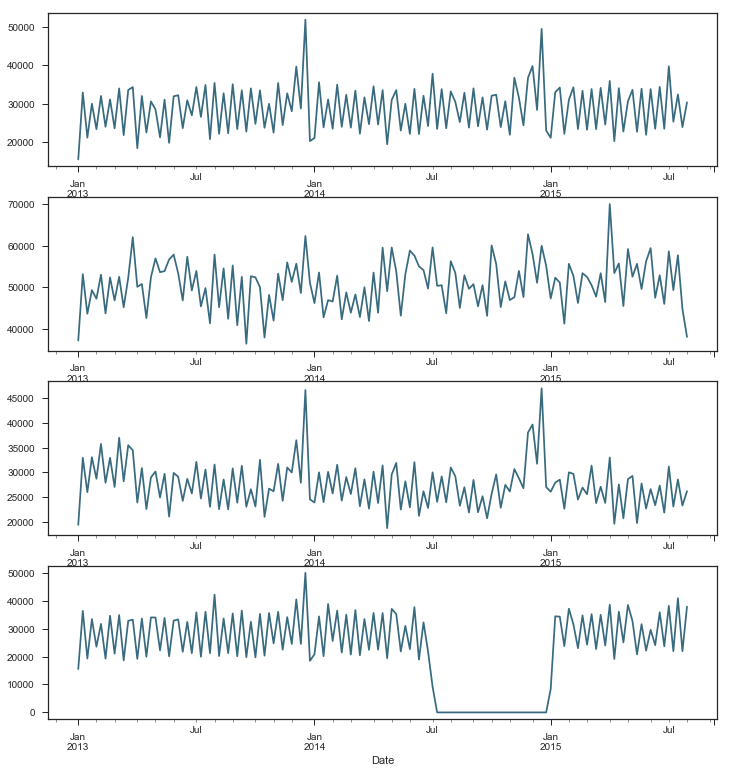

In [139]:
# preparation: input should be float type
train['Sales'] = train['Sales'] * 1.0

# store types
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending = True) # solve the reverse order
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# store types
sales_a.resample('W').sum().plot(color = c, ax = ax1)
sales_b.resample('W').sum().plot(color = c, ax = ax2)
sales_c.resample('W').sum().plot(color = c, ax = ax3)
sales_d.resample('W').sum().plot(color = c, ax = ax4)

Retail sales for StoreType A and C tend to peak for the Christmas season and then decline after the holidays. We might have seen the same trend for StoreType D (at the bottom) but there is no information from July 2014 to January 2015 about these stores as they were closed.

## Yearly trend

The next thing to check the presence of a trend in series.

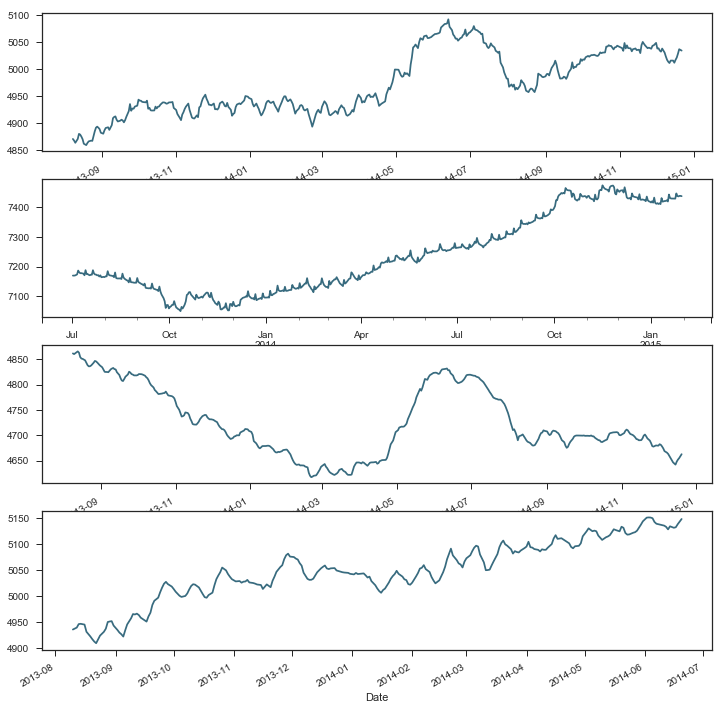

In [141]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# monthly
decomposition_a = seasonal_decompose(sales_a, model = 'additive', freq = 365)
decomposition_a.trend.plot(color = c, ax = ax1)

decomposition_b = seasonal_decompose(sales_b, model = 'additive', freq = 365)
decomposition_b.trend.plot(color = c, ax = ax2)

decomposition_c = seasonal_decompose(sales_c, model = 'additive', freq = 365)
decomposition_c.trend.plot(color = c, ax = ax3)

decomposition_d = seasonal_decompose(sales_d, model = 'additive', freq = 365)
decomposition_d.trend.plot(color = c, ax = ax4);


Overall sales seems to increase, however not for the StoreType C (a third from the top). Eventhough the StoreType A is the most selling store type in the dataset, it seems that it cab follow the same decresing trajectory as StoreType C did.

## Autocorrelaion

The next step in ourtime series analysis is to review Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.
ACF is a measure of the correlation between the timeseries with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’tn’ with series at instant ‘t1-5’…’tn-5’ (t1-5 and tn being end points).
PACF, on the other hand, measures the correlation between the timeseries with a lagged version of itself but after eliminating the variations explained by the intervening comparisons. Eg. at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

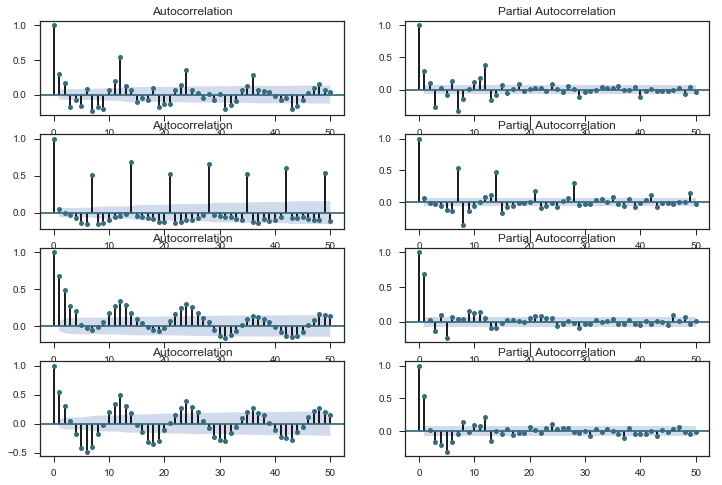

In [142]:
# figure for subplots
plt.figure(figsize = (12, 8))

# acf and pacf for A
plt.subplot(421); plot_acf(sales_a, lags = 50, ax = plt.gca(), color = c)
plt.subplot(422); plot_pacf(sales_a, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for B
plt.subplot(423); plot_acf(sales_b, lags = 50, ax = plt.gca(), color = c)
plt.subplot(424); plot_pacf(sales_b, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for C
plt.subplot(425); plot_acf(sales_c, lags = 50, ax = plt.gca(), color = c)
plt.subplot(426); plot_pacf(sales_c, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for D
plt.subplot(427); plot_acf(sales_d, lags = 50, ax = plt.gca(), color = c)
plt.subplot(428); plot_pacf(sales_d, lags = 50, ax = plt.gca(), color = c)

plt.show()

We can read these plots horizontally. Each horizontal pair is for one 'StoreType', from A to D. In general, those plots are showing the correlation of the series with itself, lagged by x time units correlation of the series with itself, lagged by x time units.
There is at two things common for each pair of plots: non randomnes of the time series and high lag-1 (which will probably need a higher order of differencing d/D).
Type A and type B: Both types show seasonalities at certain lags. For type A, it is each 12th observation with positives spikes at the 12 (s) and 24(2s) lags and so on. For type B it's a weekly trend with positives spikes at the 7(s), 14(2s), 21(3s) and 28(4s) lags.
Type C and type D: Plots of these two types are more complex. It seems like each observation is coorrelated to its adjacent observations.

In [143]:
# importing data
df = pd.read_csv("train.csv",  
                    low_memory = False)

# remove closed stores and those with no sales
df = df[(df["Open"] != 0) & (df['Sales'] != 0)]

# sales for the store number 1 (StoreType C)
sales = df[df.Store == 1].loc[:, ['Date', 'Sales']]

# reverse to the order: from 2013 to 2015
sales = sales.sort_index(ascending = False)

# to datetime64
sales['Date'] = pd.DatetimeIndex(sales['Date'])
sales.dtypes

Date     datetime64[ns]
Sales             int64
dtype: object

In [144]:
# from the prophet documentation every variables should have specific names
sales = sales.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
sales.head()

,ds,y
1014980,2013-01-02,5530
1013865,2013-01-03,4327
1012750,2013-01-04,4486
1011635,2013-01-05,4997
1009405,2013-01-07,7176


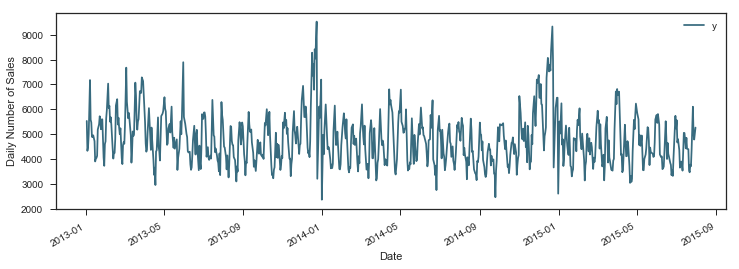

In [145]:
# plot daily sales
ax = sales.set_index('ds').plot(figsize = (12, 4), color = c)
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

Modeling Holidays
Prophet also allows to model for holidays, and that's what we do here.
The StateHoliday variable in the dataset indicates a state holiday, at which all stores are normally closed. There are also school holidays in the dataset at which ceratin stores are also closing their doors.

In [146]:
# create holidays dataframe
state_dates = df[(df.StateHoliday == 'a') | (df.StateHoliday == 'b') & (df.StateHoliday == 'c')].loc[:, 'Date'].values
school_dates = df[df.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))      
holidays.head()

,holiday,ds
0,state_holiday,2015-06-04
1,state_holiday,2015-06-04
2,state_holiday,2015-06-04
3,state_holiday,2015-06-04
4,state_holiday,2015-06-04


The ARIMA seasonal model requires 4-5 whole seasons in the data set, which may be the biggest drawback for new companies.
Seasonal ARIMA in Python has 7 hyperparameters that can only be configured manually, significantly affecting the speed of the prediction process.

Alternative approach: xgboost regression
XGBoost is an implementation of Gradient Boosted Decision trees, designed for speed and performance. Its more appropriate name is regularized Gradient Boosting, as it uses a more orderly model formalization to control reinstalling.

Importance analysis of importance: sorted bar code of the most important variables.
As we saw in the previous section, our data is extremely seasonal, not random (dependent). Therefore, before installing any models, we need to "smooth" the target variable Sales. A typical pre-processing step is the log-transformation of the data in question. Once we perform the forecasting, we are launching convert the log in reverse order.

## Quick Run through

In [93]:
# to predict to
test = pd.read_csv("test.csv", 
                    parse_dates = True, low_memory = False, index_col = 'Date')
test.head()

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,
2015-09-17,1,1,4,1.0,1,0,0
2015-09-17,2,3,4,1.0,1,0,0
2015-09-17,3,7,4,1.0,1,0,0
2015-09-17,4,8,4,1.0,1,0,0
2015-09-17,5,9,4,1.0,1,0,0


The Id variable represents a (Store, Date) duple within the test set.

In [94]:
# test: missing values?
test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [95]:
test[pd.isnull(test.Open)]

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,
2015-09-17,480,622,4,NaN,1,0,0
2015-09-16,1336,622,3,NaN,1,0,0
2015-09-15,2192,622,2,NaN,1,0,0
2015-09-14,3048,622,1,NaN,1,0,0
2015-09-12,4760,622,6,NaN,0,0,0
2015-09-11,5616,622,5,NaN,0,0,0
2015-09-10,6472,622,4,NaN,0,0,0
2015-09-09,7328,622,3,NaN,0,0,0
2015-09-08,8184,622,2,NaN,0,0,0


## Data Encoding
XGBoost doesn't support anything else than numbers. So prior to modeling we need to encode certain factor variables into numerical plus extract dates as we did before for the train set.

In [96]:
# data extraction
test['Year'] = test.index.year
test['Month'] = test.index.month
test['Day'] = test.index.day
test['WeekOfYear'] = test.index.weekofyear

# to numerical
mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
test.StateHoliday.replace(mappings, inplace = True)

train_store.Assortment.replace(mappings, inplace = True)
train_store.StoreType.replace(mappings, inplace = True)
train_store.StateHoliday.replace(mappings, inplace = True)
train_store.drop('PromoInterval', axis = 1, inplace = True)

store.StoreType.replace(mappings, inplace = True)
store.Assortment.replace(mappings, inplace = True)
store.drop('PromoInterval', axis = 1, inplace = True)

Returning back to the train_store data:

In [97]:
# take a look on the train and store again
train_store.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,CompetitionOpen,PromoOpen
0,1,5,5263,555,1,1,0,1,2015,7,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,82.0,24187.75
1,1,4,5020,546,1,1,0,1,2015,7,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,82.0,24187.75
2,1,3,4782,523,1,1,0,1,2015,7,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,82.0,24187.75
3,1,2,5011,560,1,1,0,1,2015,7,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,82.0,24187.75
4,1,1,6102,612,1,1,0,1,2015,7,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,82.0,24187.75


Let's merge test and store data too:

In [98]:
print("Joining test set with an additional store information.")
test_store = pd.merge(test, store, how = 'inner', on = 'Store')

test_store['CompetitionOpen'] = 12 * (test_store.Year - test_store.CompetitionOpenSinceYear) + (test_store.Month - test_store.CompetitionOpenSinceMonth)
test_store['PromoOpen'] = 12 * (test_store.Year - test_store.Promo2SinceYear) + (test_store.WeekOfYear - test_store.Promo2SinceWeek) / 4.0

print("In total: ", test_store.shape)
test_store.head()

Joining test set with an additional store information.
In total:  (41088, 21)


,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,...,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,CompetitionOpen,PromoOpen
0,1,1,4,1.0,1,0,0,2015,9,17,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,84.0,24189.50
1,857,1,3,1.0,1,0,0,2015,9,16,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,84.0,24189.50
2,1713,1,2,1.0,1,0,0,2015,9,15,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,84.0,24189.50
3,2569,1,1,1.0,1,0,0,2015,9,14,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,84.0,24189.50
4,3425,1,7,0.0,0,0,0,2015,9,13,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,84.0,24189.25


## Model training

In [35]:
df = pd.read_csv('train.csv')
store = pd.read_csv('store.csv')
test = pd.read_csv('test.csv')

In [36]:
test.fillna(1, inplace=True)
df = df[df["Open"] != 0]
df = df[df["Sales"] > 0]
df['log_sales'] = np.log(df['Sales'])
df = pd.merge(df, store, on='Store')
test = pd.merge(test, store, on='Store')
df.fillna(0,inplace=True)
test.fillna(0,inplace=True)

In [37]:
df["StateHoliday"] = df["StateHoliday"].map({0: 0, "0": 0, "a": 1, "b": 1, "c": 1})
test["StateHoliday"] = test["StateHoliday"].map({0: 0, "0": 0, "a": 1, "b": 1, "c": 1})
df['StateHoliday'] = df['StateHoliday'].astype(float)
test['StateHoliday'] = test['StateHoliday'].astype(float)

In [38]:
df.head().Date

0    2015-07-31
1    2015-07-30
2    2015-07-29
3    2015-07-28
4    2015-07-27
Name: Date, dtype: object

### Again extracting day , month and year

In [39]:
def extract1(x):
    return int(str(x)[:4])

def extract2(x):
    return int(str(x)[5:7])

def extract3(x):
    return (str(x)[:7])

In [40]:
df["year"]=df.Date.apply(extract1)
df["month"]=df.Date.apply(extract2)

In [41]:
df["Day"]=df.Date.apply(lambda x: int(str(x)[8:10]))

In [42]:
test["year"]=test.Date.apply(extract1)
test["month"]=test.Date.apply(extract2)
test["Day"]=test.Date.apply(lambda x: int(str(x)[8:10]))

### Now getting dummies

In [43]:
df = pd.get_dummies(df,columns=['StoreType','Assortment','year'])
test = pd.get_dummies(test,columns=['StoreType','Assortment','year'])
test['year_2013']=0
test['year_2014']=0

In [44]:
X = df.drop(['Sales','log_sales','Store','Date','Customers','CompetitionOpenSinceYear','Promo2SinceYear','PromoInterval'] , axis = 1)
y = df['log_sales']

In [45]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=7)
X_test = test.drop(['Id','Store','Date' ,'CompetitionOpenSinceYear','Promo2SinceYear','PromoInterval'] , axis = 1)

In [46]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X_train , y_train)
pred = reg.predict(X_val)

In [48]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_val,pred))
print(rmse)

0.3731435568682413


All the grid searchs are performed piecewise and looked for locally best parameters and thereafter shifted to the new parameters accordingly to make it computationally less expensive.

In [49]:
from sklearn.model_selection import GridSearchCV
model = linear_model.Ridge(random_state = 1)

param_grid = {
"alpha" : [0.01 , 0.2 , 0.250 , 0.3] 
}
grid = GridSearchCV( model , param_grid , cv = 7 , scoring = "neg_mean_squared_error")
grid.fit(X,y)

GridSearchCV(cv=7, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=1, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.01, 0.2, 0.25, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [50]:
grid.best_score_

-0.14055928229964249

In [51]:
rmse = np.sqrt(-grid.best_score_)
print(rmse)

0.3749123661599367


Even after repeated PIECE WISE gridsearchCV the min RMSE is 0.3749 which is still greater than linear regression using Ordinary Least Squares

In [52]:
from sklearn import tree
clf = tree.DecisionTreeRegressor()
clf.fit(X_train , y_train)
pred = clf.predict(X_val)

In [53]:
rmse = np.sqrt(mean_squared_error(y_val,pred))
print(rmse)

0.1815802090146207


Without parameter tuning the decision tree regressor is giving 0.1816 as RMSE which is quite good in comparison with Lasso , Ridge , etc. But above training was not cross-validated as Lasso and Ridge were.

## Ensemble Techniques

In [54]:
from sklearn.ensemble import RandomForestRegressor 
rf = RandomForestRegressor(n_estimators=100,max_depth=15)
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_val)

In [55]:
rmse_rf = np.sqrt(mean_squared_error(y_val,rf_pred))
rmse_rf

0.23691133088624405

In [ ]:
from xgboost import XGBRegressor
xgb = XGBRegressor(max_depth=15,n_jobs=4,n_estimators=120,subsample=0.7)
xgb.fit(X_train,y_train)
xg_pred = xgb.predict(X_val)
rmse_xgb = np.sqrt(mean_squared_error(y_val,xg_pred))
rmse_xgb

0.10878699388266606

XGBoost Regressor achieved a considerably low RMSE of 0.10874 and did really well in this case.

In [ ]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
xgb = XGBRegressor(max_depth=15,n_jobs=4,n_estimators=120,subsample=0.7)
scores = cross_val_score(xgb, X , y , cv=5)
scores

In [ ]:
from xgboost import XGBRegressor
xgb_final = XGBRegressor(max_depth=15,n_jobs=4,n_estimators=120,subsample=0.7)
xgb_final.fit(X,y)

In [ ]:
ranks = np.argsort(-xgb_final.feature_importances_)
f, ax = plt.subplots(figsize=(15, 10))

sns.barplot(x=xgb_final.feature_importances_[ranks], y=X_train.columns.values[ranks], orient='h')
ax.set_xlabel("Importance Of Features")
plt.tight_layout()
plt.show()

In [ ]:
a = X_test["year_2015"]

In [ ]:
X_test["year_2015"] = a

In [ ]:
X_test.columns

In [ ]:
final_predictions = xgb_final.predict(X_test)

In [ ]:
dic = {
    'Id':test['Id'].astype(int),
    'Sales': np.exp(final_predictions)
}

xgb_sub = pd.DataFrame(dic ,columns=['Id','Sales'])

In [ ]:
xgb_sub.head()

In [ ]:
result = xgb_sub.sort_values(by='Id',ascending=True)
result.to_csv('result.csv',index=False)

In [ ]:
result.head()

Approach
Split train data to train and test set to evaluate the model.
Set eta to a relatively high value (e.g. 0.05 ~ 0.1), num_round to 300 ~ 500
Use grid search to find the best combination of additional parameters.
Lower eta until we reach the optimum.
Use the validation set as watchlist to retrain the model with the best parameters.

Feature importance scores help us see which variables contributed the most to the score.

In [ ]:
xgb.plot_importance(model_final)

Variables Store and CompetitionDistance are both leading. Then go features CompetitionOpenSinceMonth, CompetitionOpenSinceYear, DayOfWeek, PromoSinceWeek and deducted features PromoOpen.

## Prediction to unseen data

## Final thoughts
Time Series Analysis is a must for time series data. In the meantime, the most sophisticated tool for the Time Series Analysis stays ARIMA.
A significant jump in the forecasting performance of the model fitted above, XGboost with xgboost library, can be achieved by increasing the number and range of hyperparameters. Due to the number of observations (800k) and with a laptop like mine, the "more developped" grid search would take about 2-3 days to fit. So I left this room for the improvement for later notebooks.
Thank you for reading!
